<a href="https://colab.research.google.com/github/Blazekiller8/SalvageAI/blob/main/yolo_nas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installations
!pip install super-gradients
!pip install torch
!pip install roboflow
!pip install supervision

# Restart kerel/runtime after installation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 11.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler

In [1]:
# Import the dataset from Roboflow
import roboflow
from roboflow import Roboflow

# Without API Key
# roboflow.login()
# rf = Roboflow()

# With API Key
rf = Roboflow(api_key="VXuKU01F5G92IbaueYM1")
project = rf.workspace("d2r-vmode").project("salvageai")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SalvageAI-1 in yolov5pytorch:: 100%|██████████| 8012/8012 [00:07<00:00, 1102.10it/s]


In [2]:
# Imports
import os
import requests
import torch
import zipfile
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
   DetectionMetrics_050,
   DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

[2024-01-20 09:44:54] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-01-20 09:44:54] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /root/sg_logs/console.log


[2024-01-20 09:44:55] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-01-20 09:45:01] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-20 09:45:01] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-20 09:45:01] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [3]:
# Configurations
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints'
    EXPERIMENT_NAME = project.name.lower().replace(" ", "_")
    LOCATION = dataset.location
    CLASSES = sorted(project.classes.keys())
    NUM_CLASSES = len(CLASSES)

    #dataset params
    DATA_DIR = LOCATION #parent directory to where data lives
    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid/labels' #child dir of DATA_DIR where validation labels are

    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }
    MAX_EPOCHS = 6

    # model params
    MODEL_NAME = 'yolo_nas_s' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    CONFIDENCE_TRESHOLD = 0.2 # Note, you can set the confidence threshold value as you please.

In [4]:
# Initialize the Trainer
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

[2024-01-20 09:45:16] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2200/2200 [00:00<00:00, 4991.24it/s]
[2024-01-20 09:45:16] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1700/1700 [00:00<00:00, 5017.96it/s]
[2024-01-20 09:45:17] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 100/100 [00:00<00:00, 2943.91it/s]


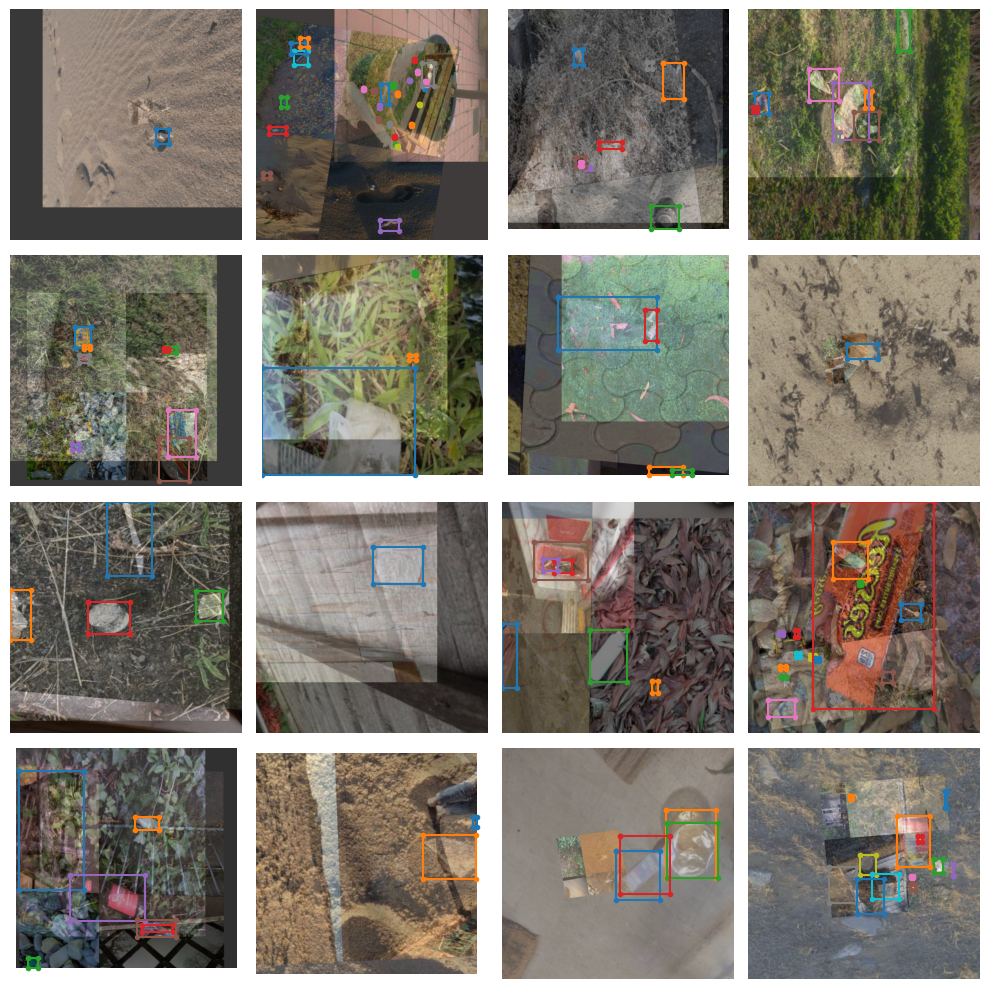

In [5]:
# Load the Datasets and Dataloaders
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

train_data.dataset.plot()

In [6]:
# Instantiate the Model
model = models.get(config.MODEL_NAME,
                  num_classes=config.NUM_CLASSES,
                  pretrained_weights=config.PRETRAINED_WEIGHTS
                  ).to(config.DEVICE)

[2024-01-20 09:45:35] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 169MB/s]
[2024-01-20 09:45:37] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [7]:
# Define metrics and training parameters
train_params = {
   'silent_mode': False,
   "average_best_models":True,
   "warmup_mode": "linear_epoch_step",
   "warmup_initial_lr": 1e-6,
   "lr_warmup_epochs": 3,
   "initial_lr": 5e-4,
   "lr_mode": "cosine",
   "cosine_final_lr_ratio": 0.1,
   "optimizer": "Adam",
   "optimizer_params": {"weight_decay": 0.0001},
   "zero_weight_decay_on_bias_and_bn": True,
   "ema": True,
   "ema_params": {"decay": 0.9, "decay_type": "threshold"},
   "max_epochs": config.MAX_EPOCHS,
   "mixed_precision": True,
   "loss": PPYoloELoss(
       use_static_assigner=False,
       num_classes=config.NUM_CLASSES,
       reg_max=16
   ),
   "valid_metrics_list": [
       DetectionMetrics_050_095(
           score_thres=0.1,
           top_k_predictions=300,
           num_cls=config.NUM_CLASSES,
           normalize_targets=True,
           post_prediction_callback=PPYoloEPostPredictionCallback(
               score_threshold=0.01,
               nms_top_k=1000,
               max_predictions=300,
               nms_threshold=0.7
           )
       )
   ],
   "metric_to_watch": 'mAP@0.50:0.95'
}


In [8]:
#  Evaluate the Model before training
trainer.test(model=model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,                                                                              nms_threshold=0.7)
                                                  ))

Testing:  83%|████████▎ | 5/6 [00:07<00:00,  1.24it/s]

{'Precision@0.50': 7.830376853235066e-05,
 'Recall@0.50': 0.005252100992947817,
 'mAP@0.50': 1.2973454431630671e-05,
 'F1@0.50': 0.00015105545753613114}

Testing: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


In [9]:
# Train the model
trainer.train(
   model=model,
   training_params=train_params,
   train_loader=train_data,
   valid_loader=val_data
)

[2024-01-20 09:46:00] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240120_094600_356972`
[2024-01-20 09:46:00] INFO - sg_trainer.py - Checkpoints directory: checkpoints/salvageai/RUN_20240120_094600_356972
[2024-01-20 09:46:00] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})


The console stream is now moved to checkpoints/salvageai/RUN_20240120_094600_356972/console_Jan20_09_46_00.txt


[2024-01-20 09:46:08] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            2200       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         137        (len(train_loader))
    - Gradient updates per epoch:   137        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.03M parameters, 19.03M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.03M parameters). LR: 0.0005 (19.03M parameters) WD: 0.0, (42.18K parameters), WD: 0.0001, (18.98M parameters)

[2024-01-20 09:46:08] INFO - sg_trainer.py - Started training for 6

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.757
│   ├── Ppyoloeloss/loss_iou = 0.7096
│   ├── Ppyoloeloss/loss_dfl = 0.6854
│   └── Ppyoloeloss/loss = 4.1519
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.7697
    ├── Ppyoloeloss/loss_iou = 0.5066
    ├── Ppyoloeloss/loss_dfl = 0.527
    ├── Ppyoloeloss/loss = 3.8033
    ├── Precision@0.50:0.95 = 0.0008
    ├── Recall@0.50:0.95 = 0.0005
    ├── Map@0.50:0.95 = 0.0001
    └── F1@0.50:0.95 = 0.0002



Validating epoch 1: 100%|██████████| 106/106 [01:03<00:00,  1.66it/s]
[2024-01-20 09:57:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240120_094600_356972/ckpt_best.pth
[2024-01-20 09:57:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.02251340076327324


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.7673
│   │   ├── Epoch N-1      = 2.757  (↘ -0.9897)
│   │   └── Best until now = 2.757  (↘ -0.9897)
│   ├── Ppyoloeloss/loss_iou = 0.636
│   │   ├── Epoch N-1      = 0.7096 (↘ -0.0736)
│   │   └── Best until now = 0.7096 (↘ -0.0736)
│   ├── Ppyoloeloss/loss_dfl = 0.586
│   │   ├── Epoch N-1      = 0.6854 (↘ -0.0994)
│   │   └── Best until now = 0.6854 (↘ -0.0994)
│   └── Ppyoloeloss/loss = 2.9892
│       ├── Epoch N-1      = 4.1519 (↘ -1.1627)
│       └── Best until now = 4.1519 (↘ -1.1627)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6642
    │   ├── Epoch N-1      = 2.7697 (↘ -1.1055)
    │   └── Best until now = 2.7697 (↘ -1.1055)
    ├── Ppyoloeloss/loss_iou = 0.5083
    │   ├── Epoch N-1      = 0.5066 (↗ 0.0017)
    │   └── Best until now = 0.5066 (↗ 0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.4681
    │   ├── Epoch N-1      = 0.527  (↘ -0.0589)
    │   └── Best until now = 0.527  (↘ -0.0589)
    ├── Ppyoloeloss/loss =

Validating epoch 2: 100%|██████████| 106/106 [00:57<00:00,  1.83it/s]
[2024-01-20 10:03:22] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240120_094600_356972/ckpt_best.pth
[2024-01-20 10:03:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.023632057011127472


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.5662
│   │   ├── Epoch N-1      = 1.7673 (↘ -0.2011)
│   │   └── Best until now = 1.7673 (↘ -0.2011)
│   ├── Ppyoloeloss/loss_iou = 0.6057
│   │   ├── Epoch N-1      = 0.636  (↘ -0.0303)
│   │   └── Best until now = 0.636  (↘ -0.0303)
│   ├── Ppyoloeloss/loss_dfl = 0.5649
│   │   ├── Epoch N-1      = 0.586  (↘ -0.0211)
│   │   └── Best until now = 0.586  (↘ -0.0211)
│   └── Ppyoloeloss/loss = 2.7368
│       ├── Epoch N-1      = 2.9892 (↘ -0.2525)
│       └── Best until now = 2.9892 (↘ -0.2525)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.9022
    │   ├── Epoch N-1      = 1.6642 (↗ 0.238)
    │   └── Best until now = 1.6642 (↗ 0.238)
    ├── Ppyoloeloss/loss_iou = 0.4906
    │   ├── Epoch N-1      = 0.5083 (↘ -0.0177)
    │   └── Best until now = 0.5066 (↘ -0.016)
    ├── Ppyoloeloss/loss_dfl = 0.4813
    │   ├── Epoch N-1      = 0.4681 (↗ 0.0133)
    │   └── Best until now = 0.4681 (↗ 0.0133)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 3: 100%|██████████| 106/106 [00:59<00:00,  1.79it/s]
[2024-01-20 10:09:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240120_094600_356972/ckpt_best.pth
[2024-01-20 10:09:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.030305247753858566


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.53
│   │   ├── Epoch N-1      = 1.5662 (↘ -0.0361)
│   │   └── Best until now = 1.5662 (↘ -0.0361)
│   ├── Ppyoloeloss/loss_iou = 0.5872
│   │   ├── Epoch N-1      = 0.6057 (↘ -0.0185)
│   │   └── Best until now = 0.6057 (↘ -0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.5631
│   │   ├── Epoch N-1      = 0.5649 (↘ -0.0018)
│   │   └── Best until now = 0.5649 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 2.6804
│       ├── Epoch N-1      = 2.7368 (↘ -0.0564)
│       └── Best until now = 2.7368 (↘ -0.0564)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.0798
    │   ├── Epoch N-1      = 1.9022 (↗ 0.1776)
    │   └── Best until now = 1.6642 (↗ 0.4156)
    ├── Ppyoloeloss/loss_iou = 0.484
    │   ├── Epoch N-1      = 0.4906 (↘ -0.0067)
    │   └── Best until now = 0.4906 (↘ -0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.4866
    │   ├── Epoch N-1      = 0.4813 (↗ 0.0053)
    │   └── Best until now = 0.4681 (↗ 0.0186)
    ├── Ppyoloeloss/loss = 3.

Validating epoch 4: 100%|██████████| 106/106 [00:54<00:00,  1.95it/s]
[2024-01-20 10:14:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240120_094600_356972/ckpt_best.pth
[2024-01-20 10:14:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.04400535300374031


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4945
│   │   ├── Epoch N-1      = 1.53   (↘ -0.0356)
│   │   └── Best until now = 1.53   (↘ -0.0356)
│   ├── Ppyoloeloss/loss_iou = 0.5645
│   │   ├── Epoch N-1      = 0.5872 (↘ -0.0227)
│   │   └── Best until now = 0.5872 (↘ -0.0227)
│   ├── Ppyoloeloss/loss_dfl = 0.5467
│   │   ├── Epoch N-1      = 0.5631 (↘ -0.0165)
│   │   └── Best until now = 0.5631 (↘ -0.0165)
│   └── Ppyoloeloss/loss = 2.6056
│       ├── Epoch N-1      = 2.6804 (↘ -0.0748)
│       └── Best until now = 2.6804 (↘ -0.0748)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5989
    │   ├── Epoch N-1      = 2.0798 (↘ -0.4809)
    │   └── Best until now = 1.6642 (↘ -0.0653)
    ├── Ppyoloeloss/loss_iou = 0.477
    │   ├── Epoch N-1      = 0.484  (↘ -0.0069)
    │   └── Best until now = 0.484  (↘ -0.0069)
    ├── Ppyoloeloss/loss_dfl = 0.468
    │   ├── Epoch N-1      = 0.4866 (↘ -0.0187)
    │   └── Best until now = 0.4681 (↘ -1e-04)
    ├── Ppyoloeloss/loss 

Validating epoch 5: 100%|██████████| 106/106 [00:56<00:00,  1.89it/s]
[2024-01-20 10:20:10] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/salvageai/RUN_20240120_094600_356972/ckpt_best.pth
[2024-01-20 10:20:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.05852627754211426


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.449
│   │   ├── Epoch N-1      = 1.4945 (↘ -0.0455)
│   │   └── Best until now = 1.4945 (↘ -0.0455)
│   ├── Ppyoloeloss/loss_iou = 0.5349
│   │   ├── Epoch N-1      = 0.5645 (↘ -0.0295)
│   │   └── Best until now = 0.5645 (↘ -0.0295)
│   ├── Ppyoloeloss/loss_dfl = 0.5218
│   │   ├── Epoch N-1      = 0.5467 (↘ -0.0249)
│   │   └── Best until now = 0.5467 (↘ -0.0249)
│   └── Ppyoloeloss/loss = 2.5057
│       ├── Epoch N-1      = 2.6056 (↘ -0.0999)
│       └── Best until now = 2.6056 (↘ -0.0999)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5399
    │   ├── Epoch N-1      = 1.5989 (↘ -0.059)
    │   └── Best until now = 1.5989 (↘ -0.059)
    ├── Ppyoloeloss/loss_iou = 0.4375
    │   ├── Epoch N-1      = 0.477  (↘ -0.0395)
    │   └── Best until now = 0.477  (↘ -0.0395)
    ├── Ppyoloeloss/loss_dfl = 0.4437
    │   ├── Epoch N-1      = 0.468  (↘ -0.0243)
    │   └── Best until now = 0.468  (↘ -0.0243)
    ├── Ppyoloeloss/loss 

[2024-01-20 10:20:16] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 6: 100%|██████████| 106/106 [00:58<00:00,  1.82it/s]


In [12]:
# Get the best trained model
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path='/content/checkpoints/salvageai/RUN_20240120_094600_356972/average_model.pth')

[2024-01-20 10:27:27] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/salvageai/RUN_20240120_094600_356972/average_model.pth EMA checkpoint.


In [13]:
#  Evaluate the best Model
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,                                                                              nms_threshold=0.7)
                                                  ))

Testing:  83%|████████▎ | 5/6 [00:04<00:00,  1.43it/s]

{'PPYoloELoss/loss_cls': 1.5145822,
 'PPYoloELoss/loss_iou': 0.46373937,
 'PPYoloELoss/loss_dfl': 0.4762275,
 'PPYoloELoss/loss': 2.454549,
 'Precision@0.50': 0.012857329100370407,
 'Recall@0.50': 0.5479445457458496,
 'mAP@0.50': 0.12925750017166138,
 'F1@0.50': 0.024929363280534744}

In [ ]:
# Predicting with the best model
best_model.predict("https://media-cdn-v2.laodong.vn/storage/newsportal/2018/9/28/633373/9-1_Opt.jpg", conf=config.CONFIDENCE_TRESHOLD).show()